<a href="https://colab.research.google.com/github/simasaadi/Urban-Sustainability-Score-Drivers-Trade-offs-and-Scenario-Simulator/blob/main/03_interpretability_and_scenarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpretability and Scenario Simulator — Urban Sustainability Score

This notebook quantifies feature influence and tests “what-if” scenarios by perturbing policy-relevant inputs while keeping all other variables fixed.


In [1]:
import os
import numpy as np
import pandas as pd


In [2]:
def find_csv(prefer_keywords=("urban", "planning")):
    candidates = []
    for base in ["/content", "/"]:
        if not os.path.exists(base):
            continue
        for f in os.listdir(base):
            if f.lower().endswith(".csv"):
                candidates.append(os.path.join(base, f))

    if not candidates:
        raise FileNotFoundError("No CSV found in /content or /. Upload the dataset again in this runtime.")

    # Prefer files with keywords in name
    preferred = []
    for p in candidates:
        name = os.path.basename(p).lower()
        if any(k in name for k in prefer_keywords):
            preferred.append(p)

    return preferred[0] if preferred else candidates[0], candidates

DATA_PATH, all_csvs = find_csv()
print("CSVs found:", all_csvs)
print("Using:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Loaded ✅", df.shape)
df.head(3)


CSVs found: ['/content/urban_planning_dataset.csv']
Using: /content/urban_planning_dataset.csv
Loaded ✅ (3476, 16)


,building_density,road_connectivity,public_transport_access,air_quality_index,green_cover_percentage,carbon_footprint,population_density,crime_rate,avg_income,renewable_energy_usage,disaster_risk_index,land_use_type_Commercial,land_use_type_Green Space,land_use_type_Industrial,land_use_type_Residential,urban_sustainability_score
0,0.367915,0.393821,0.428129,0.414830,0.238555,0.921950,0.126449,0.547160,0.932412,0.382358,0.446242,0.0,0.0,1.0,0.0,0.259239
1,0.414306,0.608445,0.658481,0.490982,0.917681,0.178213,0.325124,0.764042,0.903241,0.377167,0.936824,0.0,1.0,0.0,0.0,0.576923
2,0.827902,0.444679,0.263853,0.264529,0.077883,0.295159,0.042150,0.575736,0.208098,0.237949,0.463054,0.0,0.0,0.0,1.0,0.252844


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor

# 1) Load data
DATA_PATH = "urban_planning_dataset.csv"  # file is in Colab root
df = pd.read_csv(DATA_PATH)

# 2) Define target
TARGET = "urban_sustainability_score"

# 3) Feature matrix
X = df.drop(columns=[TARGET])
y = df[TARGET]

# 4) Train / test split (fixed seed for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 5) Train the final model used for interpretation & scenarios
best_model = HistGradientBoostingRegressor(random_state=42)
best_model.fit(X_train, y_train)

print("Setup complete ✅")
print("X shape:", X.shape)


Setup complete ✅
X shape: (3476, 15)


In [3]:
TARGET = "urban_sustainability_score"
assert TARGET in df.columns, f"Missing target column: {TARGET}"

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Ensure numeric-only features (as expected for this dataset)
non_numeric = X.columns[X.dtypes == "object"].tolist()
assert len(non_numeric) == 0, f"Non-numeric columns found: {non_numeric}"

print("X:", X.shape, "| y:", y.shape)


X: (3476, 15) | y: (3476,)


In [4]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2780, 15) Test: (696, 15)


In [5]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(
    random_state=RANDOM_STATE,
    max_depth=6,
    learning_rate=0.05,
    max_iter=400
)

model.fit(X_train, y_train)
print("Model fit ✅")


Model fit ✅


In [6]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, X_test, y_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring="r2"
)

importances = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

importances.head(15)


,feature,importance_mean,importance_std
4,green_cover_percentage,0.820960,0.041266
9,renewable_energy_usage,0.360091,0.007676
10,disaster_risk_index,0.204882,0.007074
5,carbon_footprint,0.197252,0.008361
2,public_transport_access,0.081107,0.003428
7,crime_rate,0.077510,0.002729
6,population_density,0.000034,0.000044
0,building_density,0.000024,0.000029
12,land_use_type_Green Space,0.000012,0.000007
8,avg_income,0.000005,0.000042


In [10]:
def clip_01(s: pd.Series) -> pd.Series:
    return s.clip(lower=0.0, upper=1.0)

def run_scenario(baseline_row: pd.Series, changes: dict) -> float:
    x = baseline_row.copy()
    for k, v in changes.items():
        assert k in x.index, f"Unknown feature: {k}"
        x[k] = v
    x = clip_01(x)
    return float(model.predict(pd.DataFrame([x]))[0])


In [11]:
baseline = X.median(numeric_only=True)
baseline_pred = run_scenario(baseline, {})
baseline_pred


0.4809436737817516

In [9]:
import numpy as np
import pandas as pd

# 1) Choose a representative baseline row (median city profile)
feature_cols = [c for c in X.columns]  # X is your model input dataframe
baseline = X[feature_cols].median(numeric_only=True)

# If median produced NaNs (rare), fallback to a real row
if baseline.isna().any():
    baseline = X[feature_cols].iloc[0]

baseline = baseline.copy()

# 2) Baseline prediction (make it a 1-row dataframe to match sklearn expectations)
baseline_df = pd.DataFrame([baseline], columns=feature_cols)
baseline_pred = float(best_model.predict(baseline_df)[0])

# 3) Scenario runner
def run_scenario(baseline_series, changes_dict):
    s = baseline_series.copy()
    for k, v in changes_dict.items():
        s[k] = v
    s_df = pd.DataFrame([s], columns=feature_cols)
    return float(best_model.predict(s_df)[0])

print("Baseline ready ✅  | baseline_pred =", baseline_pred)


Baseline ready ✅  | baseline_pred = 0.4591274929703233


In [10]:
scenarios = {
    "More green cover (+0.10)": {"green_cover_percentage": baseline["green_cover_percentage"] + 0.10},
    "More renewables (+0.10)": {"renewable_energy_usage": baseline["renewable_energy_usage"] + 0.10},
    "Better transit (+0.10)": {"public_transport_access": baseline["public_transport_access"] + 0.10},
}

rows = []
for name, changes in scenarios.items():
    pred = run_scenario(baseline, changes)
    rows.append({"scenario": name, "predicted_score": pred, "delta_vs_baseline": pred - baseline_pred})

scenario_results = pd.DataFrame(rows).sort_values("delta_vs_baseline", ascending=False)
scenario_results


,scenario,predicted_score,delta_vs_baseline
0,More green cover (+0.10),0.513805,0.054678
1,More renewables (+0.10),0.498771,0.039644
2,Better transit (+0.10),0.480172,0.021045


In [12]:
[name for name in globals().keys() if "model" in name.lower()]


['best_model']

In [14]:
# Select top drivers for interpretation (must exist in X_test)
top_features = [
    "green_cover_percentage",
    "renewable_energy_usage",
    "disaster_risk_index",
    "carbon_footprint"
]

# Safety check (advanced hygiene)
missing = [f for f in top_features if f not in X_test.columns]
assert len(missing) == 0, f"Missing features in X_test: {missing}"

top_features


['green_cover_percentage',
 'renewable_energy_usage',
 'disaster_risk_index',
 'carbon_footprint']

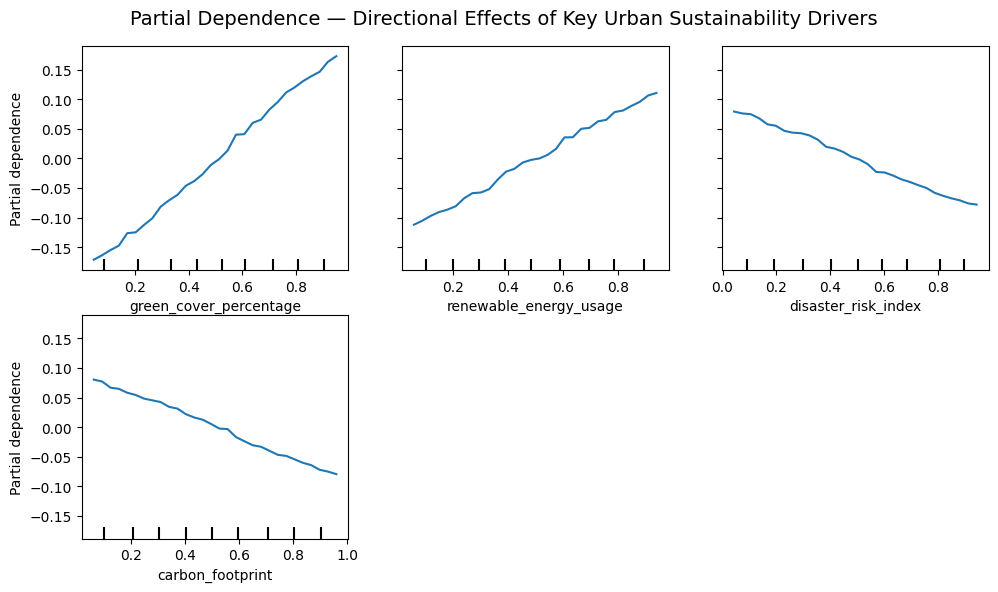

In [15]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(10, 6))

PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features=top_features,
    kind="average",
    grid_resolution=30,
    ax=ax
)

fig.suptitle(
    "Partial Dependence — Directional Effects of Key Urban Sustainability Drivers",
    fontsize=14
)
plt.tight_layout()
plt.show()


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you don't already have predictions:
pred_best = best_model.predict(X_test)

# Basic checks (prevents silent issues)
assert len(pred_best) == len(y_test)
assert isinstance(X_test, (pd.DataFrame, np.ndarray))


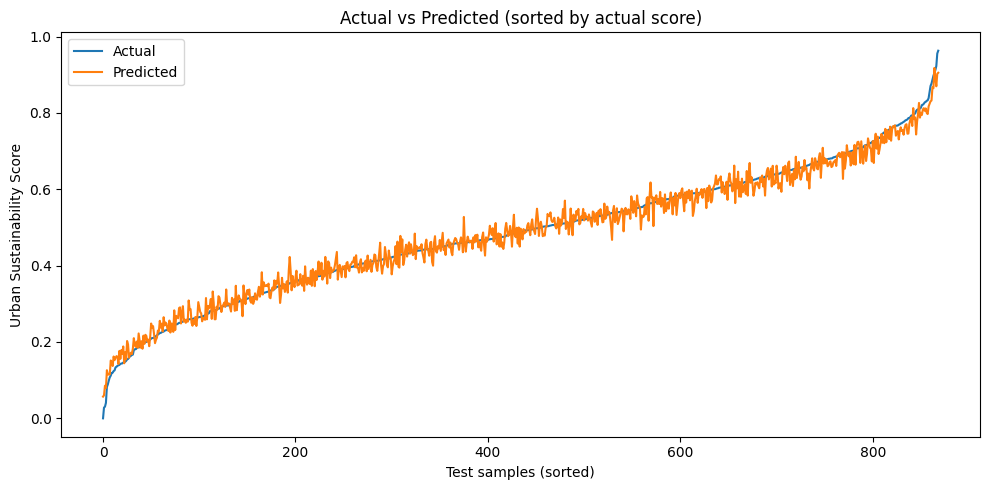

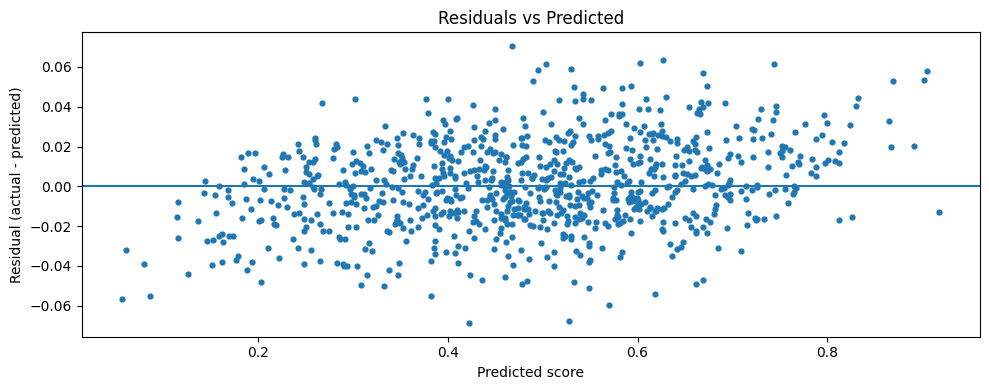

In [17]:
y_true = np.array(y_test)
y_pred = np.array(pred_best)
resid = y_true - y_pred

order = np.argsort(y_true)

plt.figure(figsize=(10, 5))
plt.plot(y_true[order], label="Actual")
plt.plot(y_pred[order], label="Predicted")
plt.title("Actual vs Predicted (sorted by actual score)")
plt.xlabel("Test samples (sorted)")
plt.ylabel("Urban Sustainability Score")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.scatter(y_pred, resid, s=12)
plt.axhline(0)
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted score")
plt.ylabel("Residual (actual - predicted)")
plt.tight_layout()
plt.show()


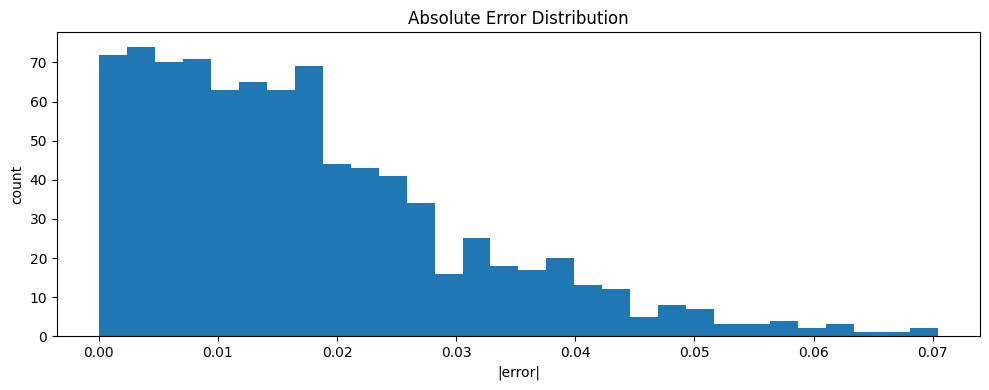

Median |error|: 0.014672475546415265
90th pct |error|: 0.03698883839719599


In [18]:
abs_err = np.abs(resid)

plt.figure(figsize=(10, 4))
plt.hist(abs_err, bins=30)
plt.title("Absolute Error Distribution")
plt.xlabel("|error|")
plt.ylabel("count")
plt.tight_layout()
plt.show()

print("Median |error|:", float(np.median(abs_err)))
print("90th pct |error|:", float(np.quantile(abs_err, 0.90)))


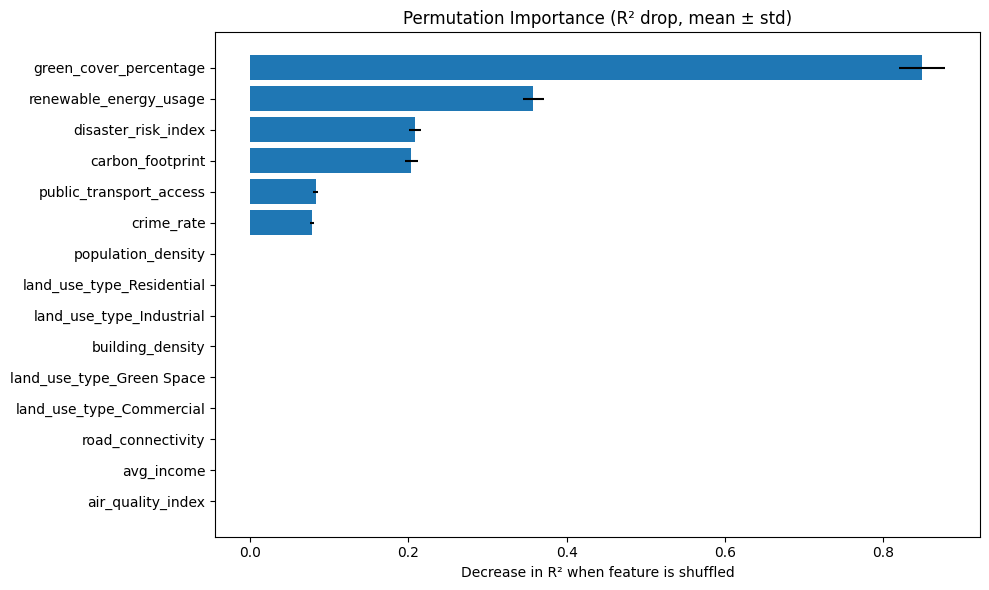

In [19]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model, X_test, y_test,
    scoring="r2",
    n_repeats=20,
    random_state=42
)

imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

top = imp.head(15).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top["feature"], top["importance_mean"], xerr=top["importance_std"])
plt.title("Permutation Importance (R² drop, mean ± std)")
plt.xlabel("Decrease in R² when feature is shuffled")
plt.tight_layout()
plt.show()


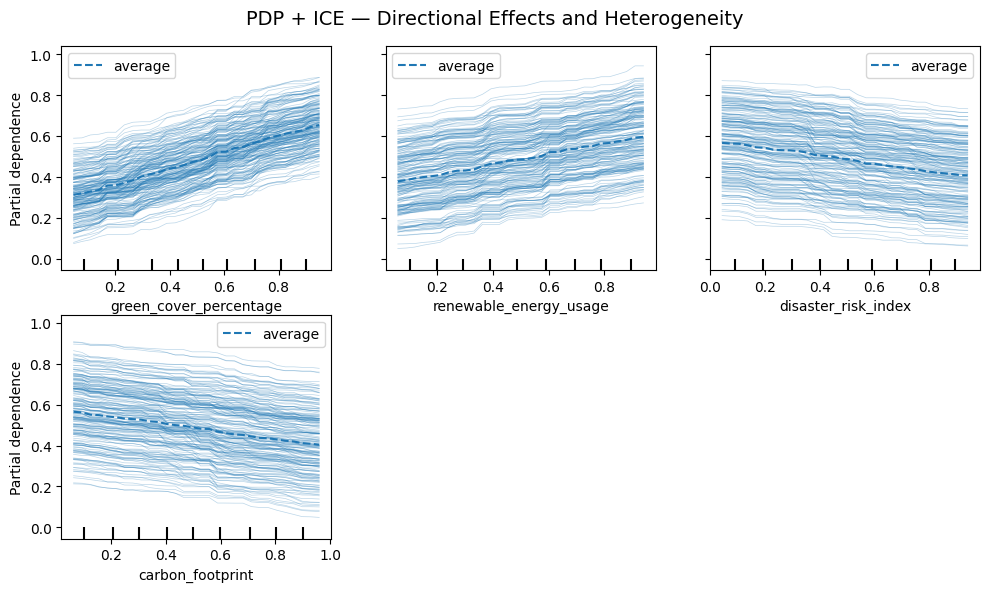

In [20]:
from sklearn.inspection import PartialDependenceDisplay

# Define top_features safely from your importance table (preferred)
top_features = imp["feature"].head(4).tolist()

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features=top_features,
    kind="both",          # PDP + ICE
    subsample=200,        # keeps it readable
    grid_resolution=30,
    random_state=42,
    ax=ax
)
fig.suptitle("PDP + ICE — Directional Effects and Heterogeneity", fontsize=14)
plt.tight_layout()
plt.show()


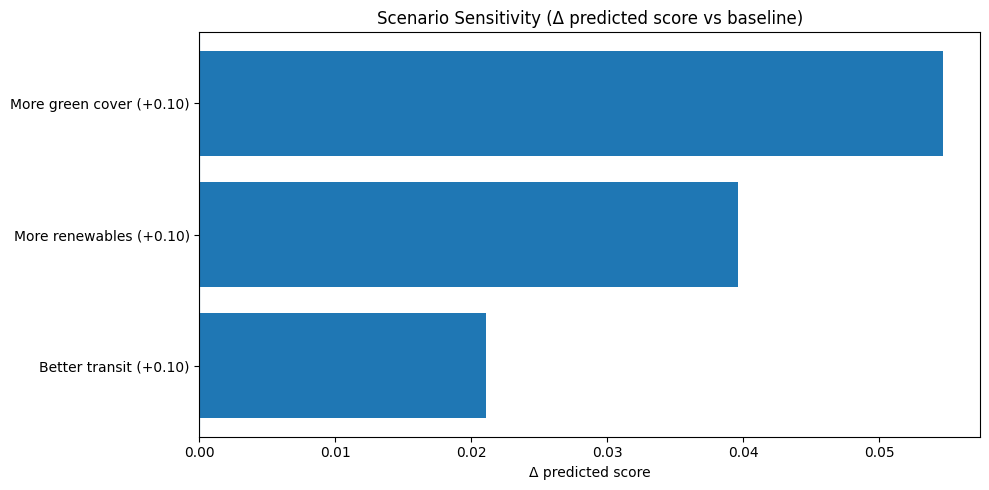

In [21]:
# scenario_results must exist with columns: scenario, delta_vs_baseline
assert "scenario_results" in globals()
assert {"scenario", "delta_vs_baseline"}.issubset(scenario_results.columns)

sr = scenario_results.sort_values("delta_vs_baseline")

plt.figure(figsize=(10, 5))
plt.barh(sr["scenario"], sr["delta_vs_baseline"])
plt.axvline(0)
plt.title("Scenario Sensitivity (Δ predicted score vs baseline)")
plt.xlabel("Δ predicted score")
plt.tight_layout()
plt.show()


In [22]:
err_df = pd.DataFrame({
    "y_true": np.array(y_test),
    "y_pred": np.array(pred_best),
})
err_df["abs_error"] = np.abs(err_df["y_true"] - err_df["y_pred"])

worst = err_df.sort_values("abs_error", ascending=False).head(10)
worst


,y_true,y_pred,abs_error
633,0.537942,0.467489,0.070454
796,0.354092,0.422791,0.068700
663,0.460095,0.527607,0.067512
848,0.690826,0.627245,0.063582
221,0.663876,0.602108,0.061768
754,0.805072,0.743621,0.061451
741,0.564900,0.503625,0.061276
37,0.510692,0.570330,0.059638
126,0.589394,0.530244,0.059150
418,0.553004,0.494621,0.058382


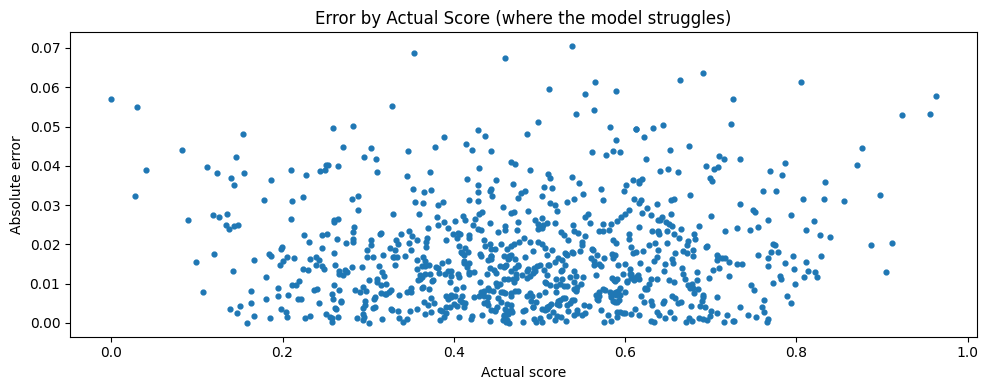

In [23]:
plt.figure(figsize=(10, 4))
plt.scatter(err_df["y_true"], err_df["abs_error"], s=12)
plt.title("Error by Actual Score (where the model struggles)")
plt.xlabel("Actual score")
plt.ylabel("Absolute error")
plt.tight_layout()
plt.show()
